In [1]:
import numpy as np
from scipy.integrate import solve_ivp,cumtrapz,cumulative_trapezoid
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, optimize, minimize,fminbound
plt.rcParams.update({
    "text.usetex": True,             # Use LaTeX for all text rendering
    "font.family": "serif",          # Use a serif font like Computer Modern
    "font.serif": ["Computer Modern"],
    "font.size": 10,                 # General font size (matches LaTeX \normalsize for 11pt)
    "axes.labelsize": 8,            # Font size for axis labels
    "axes.titlesize": 10,            # Font size for plot titles
    "legend.fontsize": 7,            # Font size for legends
    "xtick.labelsize": 6,            # Font size for x-tick labels
    "ytick.labelsize": 6,            # Font size for y-tick labels
    "axes.linewidth": 0.75,             # Line width for axes
    "lines.linewidth": 0.75,            # Line width for plot lines
    "patch.linewidth": 0.5,           # Line width for patches
    "figure.titlesize": 10
})

39.247345458971374
42.77960655027881
0.005183025591188855
2.5479430221475385
438.46055830454776
0.0002
0.46025651002454365


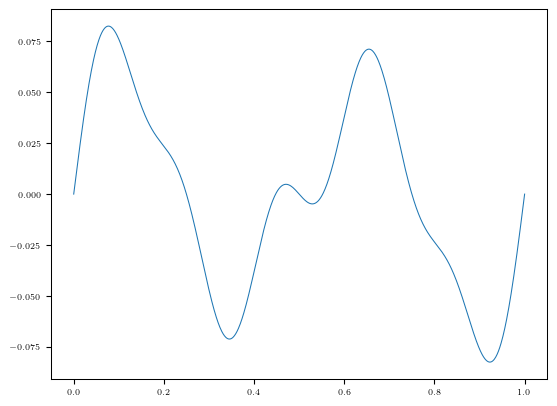

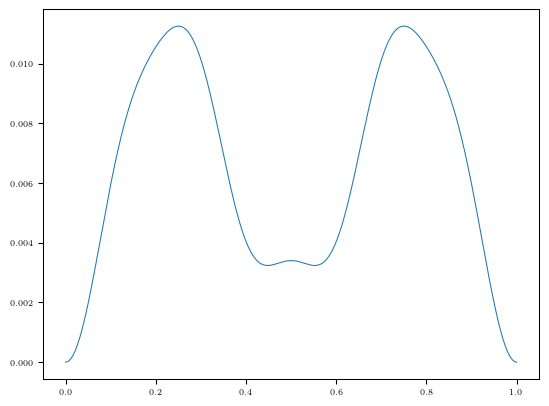

In [6]:
# scalings
L=1e5;g=9.81; m = 80; P_peloton_hat = 200 # Watts
rho = 1.225; A = 0.36;C_d_avg = 0.7
v_hat_peloton = (2*P_peloton_hat/(C_d_avg*rho*A))**(1/3)
print(v_hat_peloton*3.6) #kph
gravity_term = m*g*v_hat_peloton/P_peloton_hat
print(gravity_term)
acceleration_term = m*v_hat_peloton**3/L/P_peloton_hat
print(acceleration_term)
peloton_time = L/v_hat_peloton
print(peloton_time/3600) # hours
energy_scale = P_peloton_hat*peloton_time
print(energy_scale/4184)#kcal
omega = 1
def theta(x):
    return 0.06*((np.cos(2*np.pi*x)+np.cos(2*np.pi*x*5)/2+np.cos(2*np.pi*x*3)/7)*0+
                 np.sin(4*np.pi*x)+np.sin(2*np.pi*x*5)/3+np.sin(2*np.pi*x*3)/3)
lambda_ = 0.25
N_0 = 5
zeta_0_hat = N_0*4
zeta_0 = zeta_0_hat/L
print(zeta_0)
P_lurking = (0.05 + (1-0.05)*np.exp(-lambda_*zeta_0*L/4))/0.7
P_attack = 1.5
print(P_lurking)
plt.plot(np.linspace(0,1,1000), theta(np.linspace(0,1,1000)))
plt.show()
x_profile = np.linspace(0,1,1000)
plt.plot(x_profile, cumulative_trapezoid(np.tan(theta(x_profile)),x_profile,initial=0 ))
def C_d(zeta):
    if zeta > 0:
        return (0.05 + (1-0.05)*np.exp(-zeta*L/4*lambda_))/0.7 # you are inside the peloton
    elif zeta > 0.001:
        return 1/0.7 # you have fallen behind the peloton and you are by yourself
    else:
        return 1/0.7 # you are ahead of the peloton

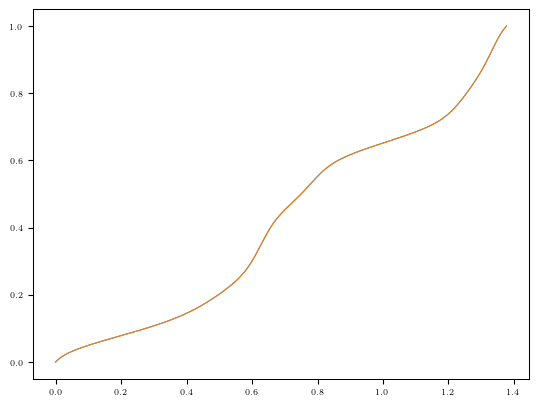

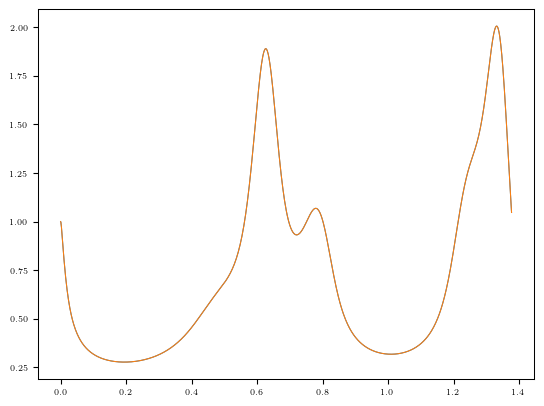

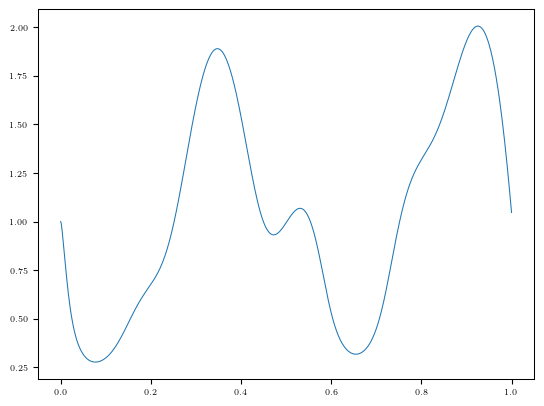

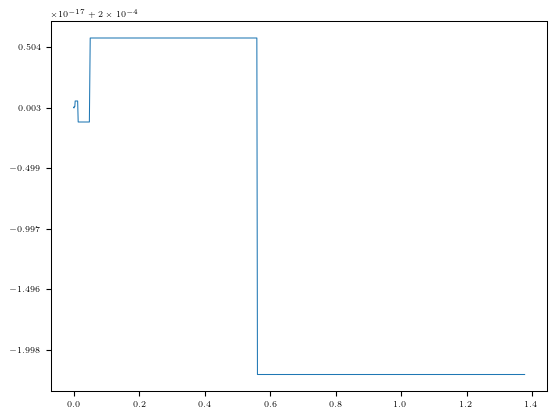

In [7]:
# the idea is the peloton is moving at a constant power. This constant power will give us the instantaneous speed of the peloton. 
# the rider moves with this instantataneous spped before their attack. As they are not at the front of the peloton their power is lower
#once they attach they choose their power and that determines their trajectory
# we need a coupled solver as the peloton will determine the speed of the rider
# first we get a solver where the inidividual rider merely tracks the peloton, no attacks
T_a = 0
def stop_condition(t,state_vec):
    return state_vec[0]-1
stop_condition.terminal = True
ic_individual = np.array([-zeta_0,1]);ic_peloton = np.array([0,1])
ic = np.concatenate([ic_peloton,ic_individual])
def RHS(t,state):
    x_p = state[0]; x_dot_p = state[1]
    x_i = state[2]; x_dot_i = state[-1]
    zeta = x_p - x_i
    dstatedt=np.zeros_like(state)
    dstatedt[0] = x_dot_p
    dstatedt[1] = 1/acceleration_term*(1/x_dot_p-x_dot_p**2-gravity_term*np.sin(theta(x_p)))
    dstatedt[2] = x_dot_p
    dstatedt[-1] = dstatedt[1]
    return dstatedt
t_span = (0,3)
solution=solve_ivp(RHS, t_span,ic, 
          events=stop_condition,method='RK45', rtol = 1e-9)
x_p=solution.y[0,:];x_dot_p=solution.y[1,:];
x_i=solution.y[2,:];x_dot_i=solution.y[-1,:]
t_eval = solution.t;
plt.plot(t_eval, x_p)
plt.plot(t_eval, x_i);plt.show()
plt.plot(t_eval, x_dot_p)
plt.plot(t_eval, x_dot_i);plt.show()
plt.plot(x_p, x_dot_p);plt.show()
plt.plot(t_eval, x_p-x_i)

In [8]:
# now the rider can attack at a constant power P_a at position x_a,
x_a = 0.5
def stop_condition(t,state_vec):
    return state_vec[0]-1
stop_condition.terminal = True
ic_individual = np.array([-zeta_0,1]);ic_peloton = np.array([0,1])
ic = np.concatenate([ic_peloton,ic_individual])
def RHS(t,state):
    x_p = state[0]; x_dot_p = state[1]
    x_i = state[2]; x_dot_i = state[-1]
    zeta = x_p - x_i
    dstatedt=np.zeros_like(state)
    dstatedt[0] = x_dot_p
    dstatedt[1] = 1/acceleration_term*(1/x_dot_p-x_dot_p**2-gravity_term*np.sin(theta(x_p)))
    if x_i<x_a:
        dstatedt[2] = x_dot_p
        dstatedt[-1] = dstatedt[1]
    elif x_i > 1.0001:
        dstatedt[2] = 0 #we have finished the race
        dstatedt[-1]= -1/acceleration_term*x_dot_i
    else:
        dstatedt[2] = x_dot_i
        dstatedt[-1] = 1/acceleration_term*(P_attack/x_dot_i-C_d(0)*x_dot_i**2-gravity_term*np.sin(theta(x_i)))
    return dstatedt
t_span = (0,3)
solution=solve_ivp(RHS, t_span,ic, 
          events=stop_condition,method='RK45', atol = 1e-9)
print(solution.message)
print(solution.t_events)
x_p=solution.y[0,:];x_dot_p=solution.y[1,:];
x_i=solution.y[2,:];x_dot_i=solution.y[-1,:]
t_eval = solution.t;
T_finish_rider = t_eval[np.argmin(abs(x_i-1))]; T_finish_peloton = t_eval[-1]
print(T_finish_rider)
x_ddot_i = np.gradient(x_dot_i, t_eval);x_ddot_p = np.gradient(x_dot_p, t_eval)
zeta = -(x_i-x_p)


# computing the power
C_d_vect = np.vectorize(C_d)
P_i = x_dot_i*(acceleration_term*x_ddot_i+gravity_term*np.sin(theta(x_i))+C_d_vect(zeta)*x_dot_i**2)
P_i = np.where(P_i>0,P_i,0)
P_p = x_dot_p*(acceleration_term*x_ddot_p+gravity_term*np.sin(theta(x_p))+x_dot_p**2)

A termination event occurred.
[array([1.3771174])]
1.2997535902160757


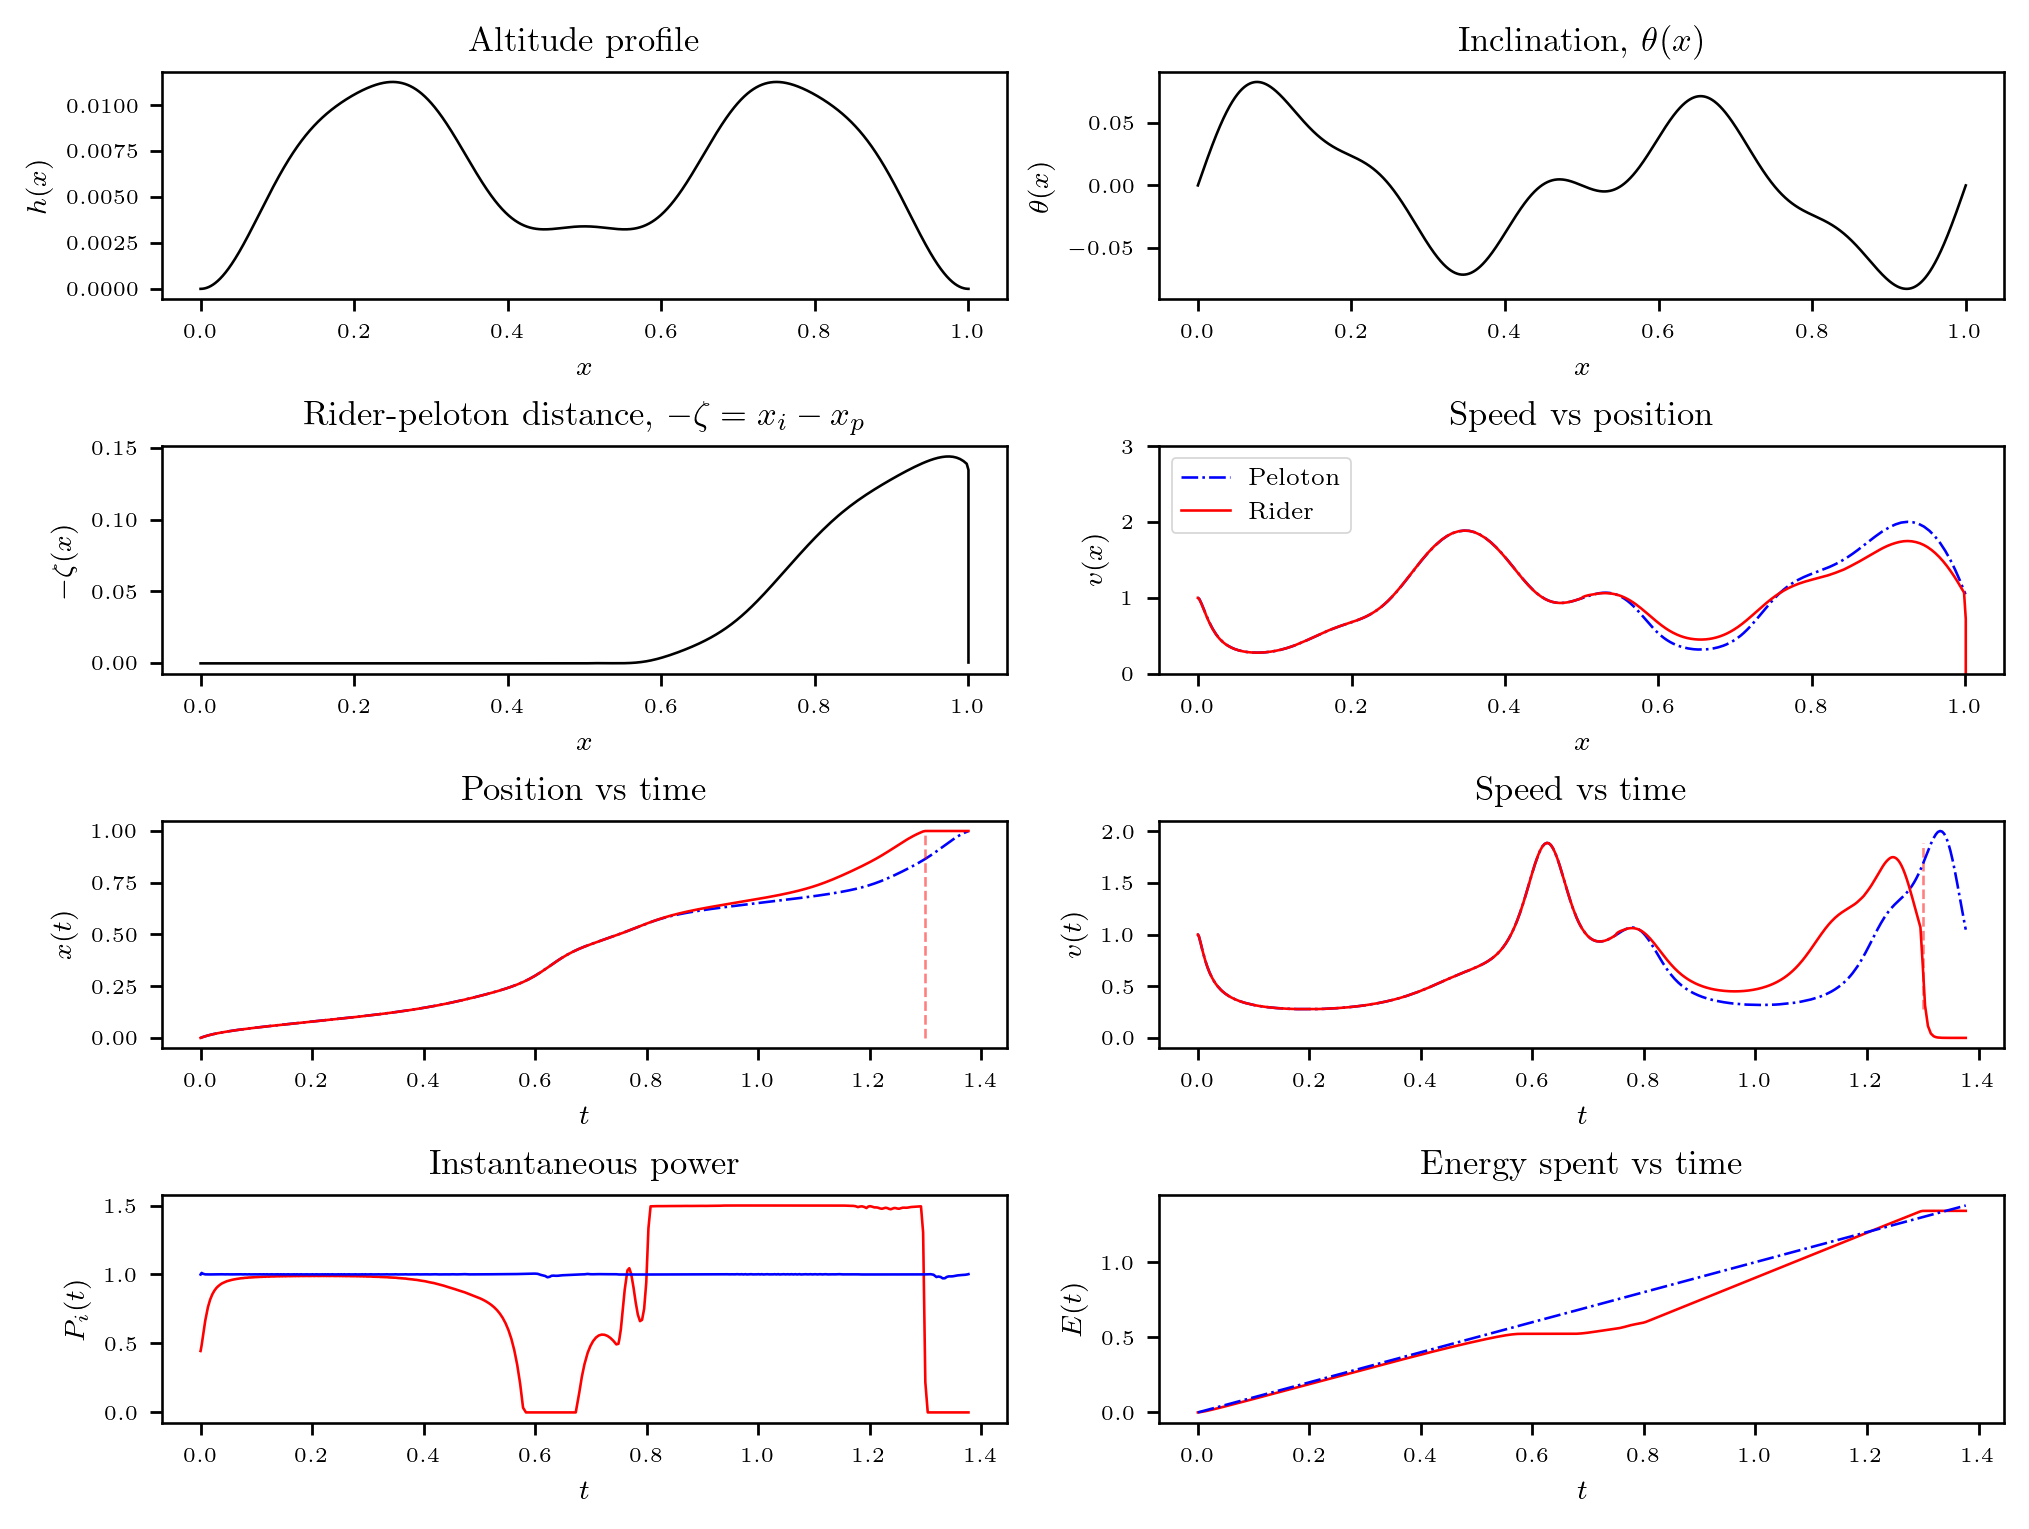

In [10]:
fig, ax = plt.subplots(nrows=4, ncols =2, figsize =(8,6),dpi=250,constrained_layout=True)
x_profile = np.linspace(0,1,5000)
ax[0,0].plot(x_profile, cumulative_trapezoid(np.tan(theta(x_profile)),x_profile,initial=0 ),color='black')
ax[0,0].set_title('Altitude profile');ax[0,0].set_xlabel('$x$');ax[0,0].set_ylabel('$h(x)$')
ax[0,1].plot(x_profile, theta(x_profile),color='black')
ax[0,1].set_title(r'Inclination, $\theta(x)$');ax[0,1].set_xlabel('$x$');ax[1,0].set_ylabel('$-\zeta(x)$')
ax[0,1].set_ylabel(r'$\theta (x)$')

ax[1,0].plot(x_i,-zeta,color='black');ax[1,0].set_title('Rider-peloton distance, $-\zeta=x_i-x_p$');ax[1,0].set_xlabel('$x$')
ax[1,1].plot(x_p, x_dot_p,'-.',color='blue',label='Peloton')
ax[1,1].plot(x_i, x_dot_i,color='red',label='Rider'); ax[1,1].set_xlabel('$x$');ax[1,1].legend()
ax[1,1].set_title('Speed vs position');ax[1,1].set_ylim([0,3]);ax[1,1].set_ylabel('$v(x)$')

ax[2,0].plot(t_eval, x_p,'-.',color='blue')
ax[2,0].plot(t_eval, x_i,color='red');ax[2,0].set_xlabel('$t$')
ax[2,1].plot(np.ones_like(np.linspace(0,1,10))*T_finish_rider, np.linspace(np.min(x_dot_p),np.max(x_dot_i),10),alpha=0.5, color='red',linestyle='--')
ax[2,0].set_title('Position vs time');ax[2,0].set_ylabel('$x(t)$')
ax[2,1].plot(t_eval, x_dot_p,'-.',color='blue')
ax[2,1].plot(t_eval, x_dot_i,color='red');ax[2,1].set_xlabel('$t$');ax[2,1].set_ylabel('$v(t)$')
ax[2,0].plot(np.ones_like(np.linspace(0,1,10))*T_finish_rider, np.linspace(0,1,10),alpha=0.5, color='red',linestyle='--')
ax[2,1].set_title('Speed vs time')

ax[3,0].plot(t_eval,P_i,color='red')
ax[3,0].plot(t_eval,P_p,color='blue');ax[3,0].set_title('Instantaneous power');ax[3,0].set_xlabel('$t$');ax[3,0].set_ylabel('$P_i(t)$')
ax[3,1].plot(t_eval, cumulative_trapezoid(P_i,t_eval,initial=0),color='red')
ax[3,1].plot(t_eval, cumulative_trapezoid(P_p,t_eval,initial=0),'-.',color='blue')
ax[3,1].set_title('Energy spent vs time');ax[3,1].set_xlabel('$t$');ax[3,1].set_ylabel('$E(t)$')

plt.savefig('elevation_example.pdf')
plt.show()